# Controller - PID

Reference:

Lecture 8 - Control I [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2008%20-%20ControlI.pdf) ]

<a href="https://colab.research.google.com/github/cirocavani/MO651-Robotics/blob/master/workspace/P2/Controller%20-%20PID%20(draft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ Start Colab Setup ]

In [ ]:
# Colab-only
#
# 1. Run this cell once.
#
# 2. Go to Menu "Edit > Notebook settings", on "Runtime type" select "OpenAI Spinning Up" and click on "Save".
#
# 3. After restart, continue running the notebook.


!echo "Clone Robotics..."
!apt-get install -y -qq git-lfs > /dev/null
!git lfs install > /dev/null 2>&1
!apt-get install -y -qq git-lfs > /dev/null
!git clone --quiet --depth=1 https://github.com/cirocavani/MO651-Robotics.git Robotics > /dev/null 2>&1
!echo "Download Packages..."
!Robotics/setup/downloads.sh > /dev/null 2>&1
!echo "Install Conda..."
!Robotics/setup/install-conda.sh > /dev/null 2>&1
!echo "Install Python..."
!Robotics/setup/install-python.sh > /dev/null 2>&1
!echo "Install Julia..."
!Robotics/setup/install-julia.sh > /dev/null 2>&1
!echo "Setup Dev..."
!Robotics/setup/setup-dev.sh > /dev/null 2>&1
!echo "Install Jupyter kernel..."
!sed -i -e 's#@.#/content/Robotics#' -e 's#"env": {}#"env": {"JULIA_DEPOT_PATH": "/content/Robotics/software/julia-env"}#' Robotics/software/jupyter-data/kernels/julia-1.2/kernel.json
!jupyter kernelspec install Robotics/software/jupyter-data/kernels/julia-1.2 > /dev/null 2>&1
!echo "Disable Colab kernel..."
!sed -i -e '/c\.IPKernelApp\.kernel\_class*/ s/^#*/#/' /etc/ipython/ipython_config.py

!echo "Install V-REP..."
!apt-get install -y -qq xvfb x11-utils > /dev/null
!Robotics/setup/install-vrep.sh > /dev/null 2>&1

!echo "Done!"

In [ ]:
# Colab-only.
# 
# After restart, run this cell.


ENV["DISPLAY"] = ":0.0"
run(pipeline(`Xvfb :0.0 -screen 0 800x600x24`;
             stdout="/root/xvfb.out", stderr="/root/xvfb.err"), wait=false)
run(pipeline(`/content/Robotics/software/vrep/vrep.sh -h /content/Robotics/vrep-data/p3dx2.ttt`;
             stdout="/root/vrep.out", stderr="/root/vrep.err"), wait=false)

In [ ]:
run(`ps auxw`)
println("\n***** Output\n")
run(`cat /root/vrep.out`)
println("\n***** Error\n")
run(`cat /root/vrep.err`)

[ End of Colab Setup ]

In [1]:
using Robotics
using LinearAlgebra
using Plots
using Images
pyplot()

Plots.PyPlotBackend()

In [2]:
plot_attrs = Dict(
    :aspect_ratio=>1,
    :framestyle=>:origin,
    :xlims=>(-5, 5),
    :ylims=>(-5, 5),
    :xticks=>-5:5,
    :yticks=>-5:5
)

plot_attrs

Dict{Symbol,Any} with 6 entries:
  :ylims        => (-5, 5)
  :xlims        => (-5, 5)
  :framestyle   => :origin
  :aspect_ratio => 1
  :xticks       => -5:5
  :yticks       => -5:5

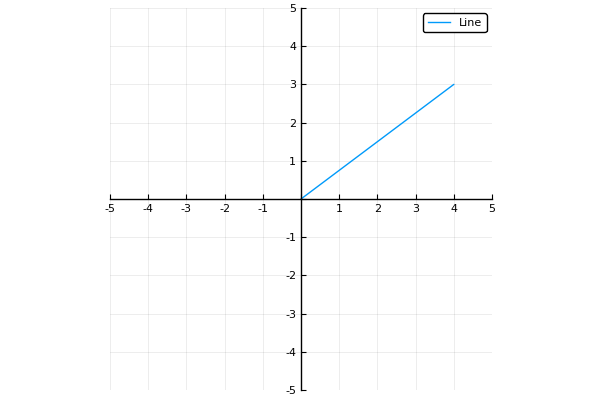

In [3]:
A = [0, 0]
B = [4, 3]

Lx, Ly = collect.(zip(A, B))

plot(Lx, Ly; label="Line", plot_attrs...)

In [4]:
u = B - A
u = u / norm(u)
v = [0 -1; 1 0] * u

norm(u), norm(v), u ⋅ v

(1.0, 1.0, 0.0)

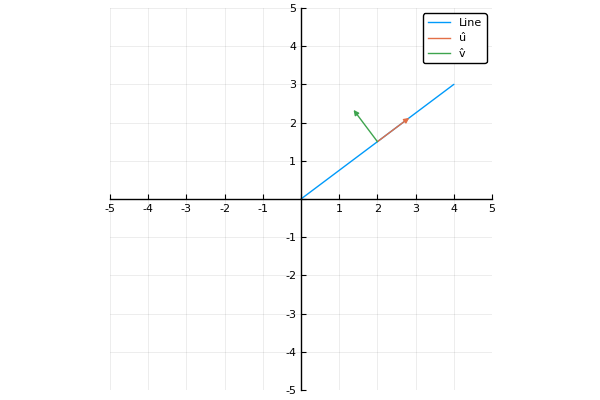

In [5]:
M = (A + B) / 2
U = M + u
V = M + v

plot(Lx, Ly; label="Line", plot_attrs...)
plot!(collect.(zip(M, U))...; label="û", arrow=:arrow)
plot!(collect.(zip(M, V))...; label="v̂", arrow=:arrow)

In [6]:
P = [1, 4]

d = (P - A) ⋅ v

2.6

In [7]:
Q = P - d * v

2-element Array{Float64,1}:
 2.56
 1.92

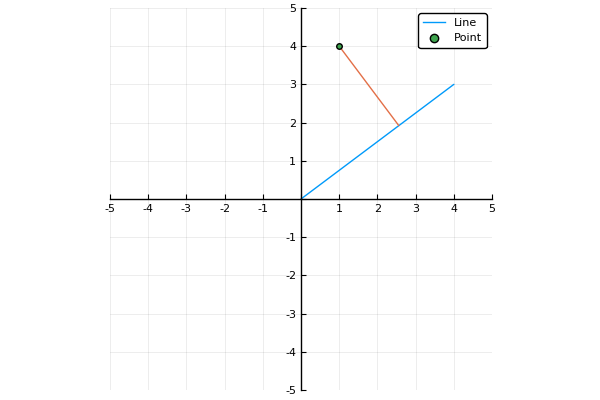

In [8]:
plot(Lx, Ly; label="Line", plot_attrs...)
plot!(collect.(zip(P, Q))...; label="")
plot!([P[1]], [P[2]]; label="Point", seriestype=:scatter)

In [9]:
θ = -90π/180

h = [cos(θ), sin(θ)]

2-element Array{Float64,1}:
  6.123233995736766e-17
 -1.0                  

In [10]:
H = P + h

2-element Array{Float64,1}:
 1.0
 3.0

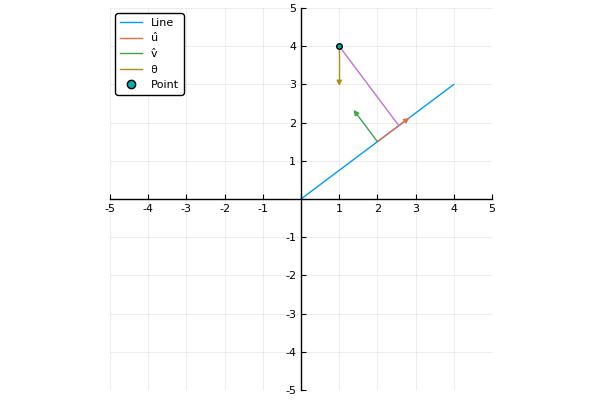

In [11]:
plot(Lx, Ly; label="Line", plot_attrs...)
plot!(collect.(zip(M, U))...; label="û", arrow=:arrow)
plot!(collect.(zip(M, V))...; label="v̂", arrow=:arrow)
plot!(collect.(zip(P, Q))...; label="")
plot!(collect.(zip(P, H))...; label="θ", arrow=:arrow)
plot!([P[1]], [P[2]]; label="Point", seriestype=:scatter)

In [12]:
∠ = acos(h ⋅ u)

2.214297435588181

In [13]:
180∠/π

126.86989764584402

In [14]:
180 - 180atan(4/3)/π

126.86989764584402

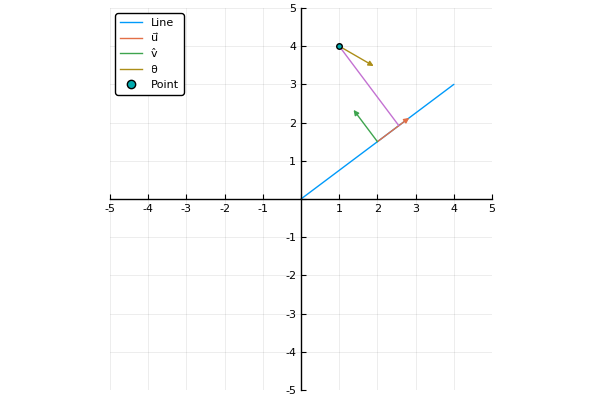

In [15]:
θʼ = -30π/180
hʼ = [cos(θʼ), sin(θʼ)]
Hʼ = P + hʼ

plot(Lx, Ly; label="Line", plot_attrs...)
plot!(collect.(zip(M, U))...; label="u⃗", arrow=:arrow)
plot!(collect.(zip(M, V))...; label="v̂", arrow=:arrow)
plot!(collect.(zip(P, Q))...; label="")
plot!(collect.(zip(P, Hʼ))...; label="θ", arrow=:arrow)
plot!([P[1]], [P[2]]; label="Point", seriestype=:scatter)

In [16]:
∠ʼ = acos(hʼ ⋅ u)

1.167099884391583

In [17]:
180∠ʼ/π

66.869897645844

In [18]:
acos(u ⋅ u)

0.0

In [19]:
acos(u ⋅ -u)

3.141592653589793

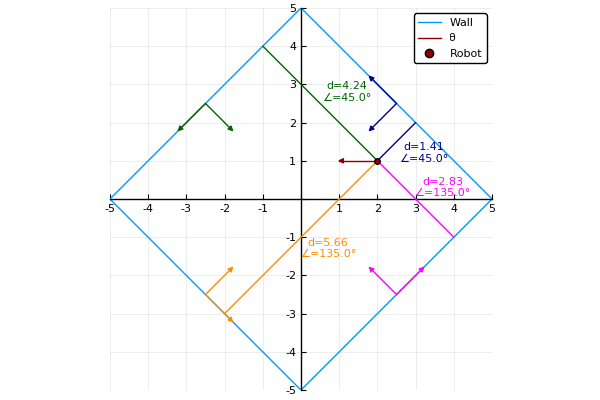

In [20]:
A = [ 5f0,  0f0]
B = [ 0f0,  5f0]
C = [-5f0,  0f0]
D = [ 0f0, -5f0]

Wx, Wy = collect.(zip(A, B, C, D, A))

u₁ = B - A
u₁ = u₁ / norm(u₁)
v₁ = [0 -1; 1 0] * u₁

u₂ = C - B
u₂ = u₂ / norm(u₂)
v₂ = [0 -1; 1 0] * u₂

u₃ = D - C
u₃ = u₃ / norm(u₃)
v₃ = [0 -1; 1 0] * u₃

u₄ = A - D
u₄ = u₄ / norm(u₄)
v₄ = [0 -1; 1 0] * u₄

M₁ = (A + B) / 2
U₁ = M₁ + u₁
V₁ = M₁ + v₁
ux₁, uy₁ = collect.(zip(M₁, U₁))
vx₁, vy₁ = collect.(zip(M₁, V₁))

M₂  = (B + C) / 2
U₂ = M₂ + u₂
V₂ = M₂ + v₂
ux₂, uy₂ = collect.(zip(M₂, U₂))
vx₂, vy₂ = collect.(zip(M₂, V₂))

M₃ = (C + D) / 2
U₃ = M₃ + u₃
V₃ = M₃ + v₃
ux₃, uy₃ = collect.(zip(M₃, U₃))
vx₃, vy₃ = collect.(zip(M₃, V₃))

M₄ = (D + A) / 2
U₄ = M₄ + u₄
V₄ = M₄ + v₄
ux₄, uy₄ = collect.(zip(M₄, U₄))
vx₄, vy₄ = collect.(zip(M₄, V₄))

P = [2f0, 1f0]
θ = Float32(π)

d₁ = (P - A) ⋅ v₁
d₂ = (P - B) ⋅ v₂
d₃ = (P - C) ⋅ v₃
d₄ = (P - D) ⋅ v₄

P₁ = P - d₁ * v₁
P₂ = P - d₂ * v₂
P₃ = P - d₃ * v₃
P₄ = P - d₄ * v₄

px₁, py₁ = collect.(zip(P₁, P))
px₂, py₂ = collect.(zip(P₂, P))
px₃, py₃ = collect.(zip(P₃, P))
px₄, py₄ = collect.(zip(P₄, P))

dx₁, dy₁ = (P + P₁) / 2 + [0.7, -0.3]
dx₂, dy₂ = (P + P₂) / 2 + [0.7, 0.3]
dx₃, dy₃ = (P + P₃) / 2 + [0.7, -0.3]
dx₄, dy₄ = (P + P₄) / 2 + [0.7, 0.3]

h = [cos(θ), sin(θ)]
H = P + h

∠₁ = acos(h ⋅ u₁)
∠₂ = acos(h ⋅ u₂)
∠₃ = acos(h ⋅ u₃)
∠₄ = acos(h ⋅ u₄)

∠°₁ = 180∠₁/π
∠°₂ = 180∠₂/π
∠°₃ = 180∠₃/π
∠°₄ = 180∠₄/π

plot(Wx, Wy; label="Wall", plot_attrs...)
plot!(ux₁, uy₁; label="", arrow=:arrow, color="darkblue")
plot!(vx₁, vy₁; label="", arrow=:arrow, color="darkblue")
plot!(ux₂, uy₂; label="", arrow=:arrow, color="darkgreen")
plot!(vx₂, vy₂; label="", arrow=:arrow, color="darkgreen")
plot!(ux₃, uy₃; label="", arrow=:arrow, color="darkorange")
plot!(vx₃, vy₃; label="", arrow=:arrow, color="darkorange")
plot!(ux₄, uy₄; label="", arrow=:arrow, color="magenta")
plot!(vx₄, vy₄; label="", arrow=:arrow, color="magenta")

plot!(px₁, py₁; label="", color="darkblue")
annotate!(dx₁, dy₁, text("d=$(round(d₁; digits=2))\n∠=$(round(∠°₁; digits=2))°", 8, "darkblue"))
plot!(px₂, py₂; label="", color="darkgreen")
annotate!(dx₂, dy₂, text("d=$(round(d₂; digits=2))\n∠=$(round(∠°₂; digits=2))°", 8, "darkgreen"))
plot!(px₃, py₃; label="", color="darkorange")
annotate!(dx₃, dy₃, text("d=$(round(d₃; digits=2))\n∠=$(round(∠°₃; digits=2))°", 8, "darkorange"))
plot!(px₄, py₄; label="", color="magenta")
annotate!(dx₄, dy₄, text("d=$(round(d₄; digits=2))\n∠=$(round(∠°₄; digits=2))°", 8, "magenta"))

plot!(collect.(zip(P, H))...; label="θ", arrow=:arrow, color="darkred")
plot!([P[1]], [P[2]]; label="Robot", seriestype=:scatter, color="darkred")

In [21]:
struct World
    A::Vector{Float32}
    B::Vector{Float32}
    C::Vector{Float32}
    D::Vector{Float32}
    u₁::Vector{Float32}
    v₁::Vector{Float32}
    u₂::Vector{Float32}
    v₂::Vector{Float32}
    u₃::Vector{Float32}
    v₃::Vector{Float32}
    u₄::Vector{Float32}
    v₄::Vector{Float32}
end

function World(A::T, B::T, C::T, D::T) where T<:Vector{Float32}
    u₁ = B - A
    u₁ = u₁ / norm(u₁)
    v₁ = [0 -1; 1 0] * u₁

    u₂ = C - B
    u₂ = u₂ / norm(u₂)
    v₂ = [0 -1; 1 0] * u₂

    u₃ = D - C
    u₃ = u₃ / norm(u₃)
    v₃ = [0 -1; 1 0] * u₃

    u₄ = A - D
    u₄ = u₄ / norm(u₄)
    v₄ = [0 -1; 1 0] * u₄

    return World(A, B, C, D, u₁, v₁, u₂, v₂, u₃, v₃, u₄, v₄)
end

w = World(A, B, C, D)

World(Float32[5.0, 0.0], Float32[0.0, 5.0], Float32[-5.0, 0.0], Float32[0.0, -5.0], Float32[-0.70710677, 0.70710677], Float32[-0.70710677, -0.70710677], Float32[-0.70710677, -0.70710677], Float32[0.70710677, -0.70710677], Float32[0.70710677, -0.70710677], Float32[0.70710677, 0.70710677], Float32[0.70710677, 0.70710677], Float32[-0.70710677, 0.70710677])

In [22]:
function wall_distances(w::World, x::T, y::T) where T<:Float32
    P = [x, y]
    d₁ = (P - w.A) ⋅ w.v₁
    d₂ = (P - w.B) ⋅ w.v₂
    d₃ = (P - w.C) ⋅ w.v₃
    d₄ = (P - w.D) ⋅ w.v₄
    return [d₁, d₂, d₃, d₄]
end

d = wall_distances(w, P...)

4-element Array{Float32,1}:
 1.4142134
 4.2426405
 5.656854 
 2.8284268

In [23]:
function wall_angles(w::World, θ::Float32)
    h = [cos(θ), sin(θ)]
    ∠₁ = acos(h ⋅ w.u₁)
    ∠₂ = acos(h ⋅ w.u₂)
    ∠₃ = acos(h ⋅ w.u₃)
    ∠₄ = acos(h ⋅ w.u₄)
    return [∠₁, ∠₂, ∠₃, ∠₄]
end

∠ = wall_angles(w, θ)

4-element Array{Float32,1}:
 0.78539824
 0.78539807
 2.3561945 
 2.3561945 

In [24]:
reset_simulation()

robot = Robot()

Simulation stopped...
Simulation started...
Connected to remoteApi server.
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Laser connected.
Vision sensor not connected.
Left motor connected.
Right motor connected.
Robot connected.


Robot(0, Int32[52, 51, 50, 49, 48, 47, 46, 45, 60, 59, 58, 57, 56, 55, 54, 53], 72, 0, Dict(:left => 35,:right => 32), 31, 0.381f0, 0.0975f0)

In [25]:
x, y, θ = pose2D(robot)

(-0.00039881468f0, -2.57206f-6, 2.9995927f-5)

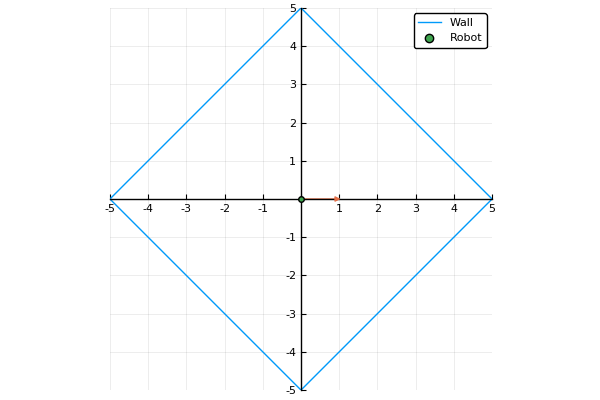

In [26]:
P = [x, y]
h = [cos(θ), sin(θ)]
H = P + h

Px, Py = collect.(zip(P, H))

Wx, Wy = collect.(zip(w.A, w.B, w.C, w.D, w.A))

plot(Wx, Wy; label="Wall", plot_attrs...)
plot!(Px, Py; label="", arrow=:arrow)
plot!([x], [y]; label="Robot", seriestype=:scatter)

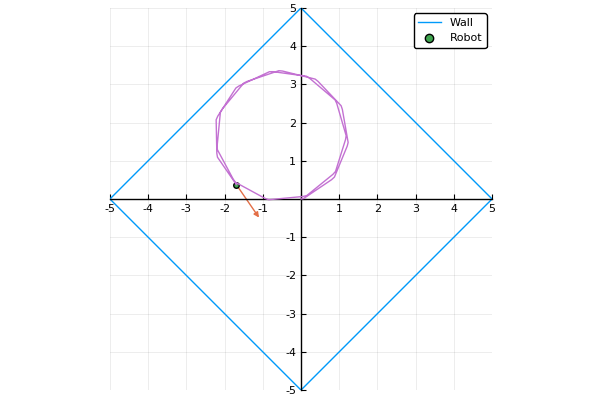

In [27]:
ω = 1.0 # rads per second

τx = zeros(Float32, 0)
τy = zeros(Float32, 0)

for _=1:20
    x_, y_, _ = pose2D(robot)
    push!(τx, x_)
    push!(τy, y_)

    set_right_velocity(robot, ω/5)
    set_left_velocity(robot, -ω/5)
    sleep(5)

    set_right_velocity(robot, ω)
    set_left_velocity(robot, ω)

    for _=1:10
        sleep(1)
        x_, y_, _ = pose2D(robot)
        push!(τx, x_)
        push!(τy, y_)
    end
end

stop(robot)

x, y, θ = pose2D(robot)
P = [x, y]
h = [cos(θ), sin(θ)]
H = P + h

Px, Py = collect.(zip(P, H))

Wx, Wy = collect.(zip(w.A, w.B, w.C, w.D, w.A))

plot(Wx, Wy; label="Wall", plot_attrs...)
plot!(Px, Py; label="", arrow=:arrow)
plot!([x], [y]; label="Robot", seriestype=:scatter)
plot!(τx, τy; label="")

Simulation stopped...
Simulation started...
Connected to remoteApi server.
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Laser connected.
Vision sensor not connected.
Left motor connected.
Right motor connected.
Robot connected.
d_min=3.459041, ∠_min=2.0577252
moving straight (too far)
d_min=3.3513505, ∠_min=2.0577133
moving straight (too far)
d_min=3.2652001, ∠_mi

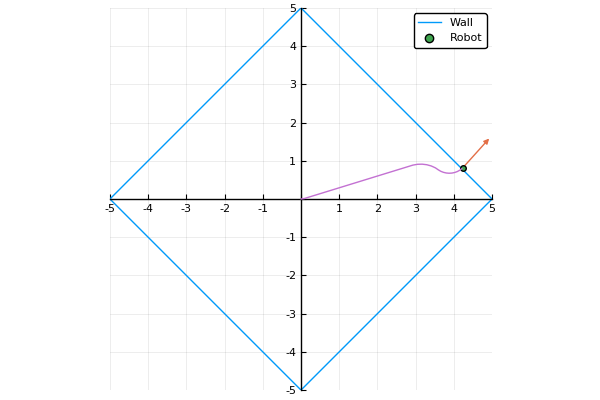

In [28]:
release(robot)
reset_simulation()

robot = Robot()

D_target = 0.5 # meters
D_toofar = 1.0
ω = 1.0 # rads per second
Δω = 0.5

function turn_left()
    println("left")
    set_left_velocity(robot, ω - Δω)
end

function turn_right()
    set_left_velocity(robot, ω + Δω)
    println("right")
end

function turn_away(∠)
    if ∠ >= π/2
        turn_left()
    else
        turn_right()
    end
end

function turn_close(∠)
    if ∠ < π/2
        turn_left()
    else
        turn_right()
    end
end

function move_straight()
    set_left_velocity(robot, ω)
end

τx = zeros(Float32, 0)
τy = zeros(Float32, 0)

x_, y_, _ = pose2D(robot)
push!(τx, x_)
push!(τy, y_)

set_right_velocity(robot, ω/10)
set_left_velocity(robot, -ω/10)
sleep(5)

set_right_velocity(robot, ω)
set_left_velocity(robot, ω)
sleep(1)

for _=1:120
    x_, y_, θ_ = pose2D(robot)
    push!(τx, x_)
    push!(τy, y_)

    d_ = wall_distances(w, x_, y_)
    ∠_ = wall_angles(w, θ_)
    
    d_min, wall_index = findmin(d_)
    ∠_min = ∠_[wall_index]

    println("d_min=$(d_min), ∠_min=$(∠_min)")
    if d_min <= 0
        println("Stopped at Wall!")
        stop(robot)
        break
    elseif d_min > D_toofar
        println("moving straight (too far)")
        move_straight()
    elseif d_min ≈ D_target
        println("moving straight (on target)")
        move_straight()
    elseif d_min < D_target
        println("turning away")
        turn_away(∠_min)
    elseif d_min > D_target
        println("turning close")
        turn_close(∠_min)
    end
    sleep(1)
end

stop(robot)

x, y, θ = pose2D(robot)
P = [x, y]
h = [cos(θ), sin(θ)]
H = P + h

Px, Py = collect.(zip(P, H))

Wx, Wy = collect.(zip(w.A, w.B, w.C, w.D, w.A))

plot(Wx, Wy; label="Wall", plot_attrs...)
plot!(Px, Py; label="", arrow=:arrow)
plot!([x], [y]; label="Robot", seriestype=:scatter)
plot!(τx, τy; label="")

In [29]:
#release(robot)